# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import pickle

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function, generate_init


from agent import Person

from model import VirusModel, VirusModel_baseline




## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [5]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': ap.IntRange(0.25,0.3), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
results_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']



Scheduled runs: 20
0.613
Completed: 1, estimated time remaining: 0:03:550.588
Completed: 2, estimated time remaining: 0:03:350.6045
Completed: 3, estimated time remaining: 0:03:240.6035
Completed: 4, estimated time remaining: 0:03:110.5905
Completed: 5, estimated time remaining: 0:03:140.595
Completed: 6, estimated time remaining: 0:03:060.5975
Completed: 7, estimated time remaining: 0:04:420.5925
Completed: 8, estimated time remaining: 0:04:300.5835
Completed: 9, estimated time remaining: 0:04:130.601
Completed: 10, estimated time remaining: 0:03:430.5765
Completed: 11, estimated time remaining: 0:03:360.5695
Completed: 12, estimated time remaining: 0:03:220.595
Completed: 13, estimated time remaining: 0:02:510.569
Completed: 14, estimated time remaining: 0:03:040.589
Completed: 15, estimated time remaining: 0:02:420.5855
Completed: 16, estimated time remaining: 0:02:160.5745
Completed: 17, estimated time remaining: 0:01:540.5825
Completed: 18, estimated time remaining: 0:01:180.595
C

In [41]:
df_baseline['misclassifications'] = (df_baseline['fraud_pred'] - df_baseline['fraud'])
df_baseline[df_baseline['fraud_pred'] ==0]['wealth'].min()

df_baseline.head()
df_baseline = df_baseline[df_baseline.fraud_pred != -1]
df_baseline[df_baseline['misclassifications'] == 0]

wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                           
0         1      1    0.226926           0      0     0       0          0   
                 2    0.232075           0      0     0       0          0   
                 5    0.249010           0      0     0       0          0   
                 6    0.255210           0      0     0       0          0   
                 7    0.261723           0      0     0       0          0   
...                        ...         ...    ...   ...     ...        ...   
19        500    96   1.000000           0      0     0       1          0   
                 97   1.000000           0      0     0       1          0   
                 98   1.000000           0      0     0       1          0   
                 99   1.000000           0      0     0       1          0   
                 100  1.000000           0      0     0       1          0   

                      misclassifications  
iteration obj_id t                        
0         1      1                     0  
                 2                     0  
                 5                     0  
                 6                     0  
                 7                     0  
...                                  ...  
19        500    96                    0  
                 97                    0  
                 98                    0  
                 99                    0  
                 100                   0  

[654374 rows x 7 columns]

In [7]:
def viz2(data, x, y):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    # plt.xlim(0,50)

    plt.show()

In [8]:
def viz(data, x, y, hue, title = None):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    # plt.xlim(0,50)
    plt.title(title)

    plt.show()

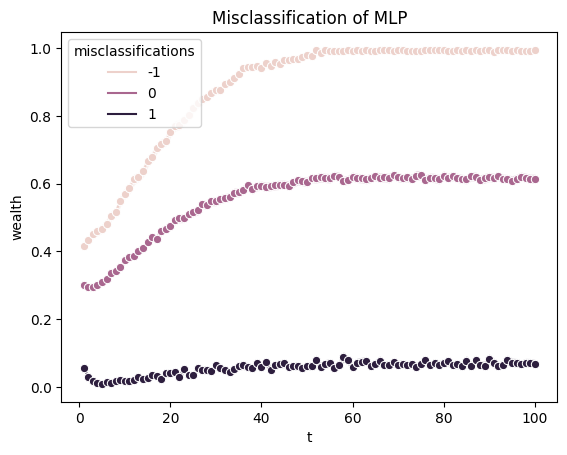

In [42]:
# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud_pred'], title= 'MLP Classifier') #, df_baseline['convicted'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud'], title = 'MLP Classifier') #, df_baseline['convicted'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['race'], df_baseline['fraud_pred'], title = 'MLP Classifier') #, df_baseline['convicted'])


viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], (df_baseline['misclassifications']), title= 'Misclassification of MLP') #, df_baseline['convicted'])

# viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'])
# viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['fraud'])
# viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['fraud_pred'])





# fig, ax = plt.subplots()

# sns.violinplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'], cut = True)

# # plt.ylim(0,0.2)
# plt.xlim(30, 60)
# # plt.title(title)

# plt.show()

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

In [10]:

# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'],
#                 hue =df_baseline['fraud_pred'],
#                 marker = 'o' )

# sns.lineplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'],
#                 hue =df_baseline['fraud'],
#                 marker = 'x' )

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# plt.title('title')

In [11]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0
df_baseline.head(400)
baseline1
# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




# df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
# df_wb0 = df_x0['wealth'] - baseline0['wealth']
# df_x0['wealth'] = df_wb0

# df_xb = pd.concat([df_x0, df_x1])

# df_xb

,wealth,fraud_pred,fraud,race,gender,convicted,misclassifications
t,,,,,,,
1,0.046115,1.0,0.561634,0.263614,0.418069,1.0,-0.438366
2,0.022305,1.0,0.585402,0.265144,0.420556,1.0,-0.414598
3,0.012576,1.0,0.597071,0.265144,0.420556,1.0,-0.402929
4,0.008397,1.0,0.614813,0.265791,0.419619,1.0,-0.385187
5,0.005428,1.0,0.619308,0.263498,0.419756,1.0,-0.380692
...,...,...,...,...,...,...,...
96,0.039713,1.0,0.603738,0.269931,0.411403,1.0,-0.396262
97,0.039608,1.0,0.585250,0.270809,0.409296,1.0,-0.414750
98,0.041906,1.0,0.596877,0.268512,0.410930,1.0,-0.403123


In [12]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.6, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': None, # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
r_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_b = r_baseline['variables']['Person']


Scheduled runs: 20
Completed: 20, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:02:10.992159


In [21]:
df_b['misclassifications'] = (df_b['fraud'] - df_b['fraud_pred'])
df_b[df_b['fraud_pred'] ==0]['wealth'].min()

df_b.head()
df_b = df_b[df_b.fraud_pred != -1]
df_b['wealth'] <0.5

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_71273/2273734016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b['misclassifications'] = (df_b['fraud'] - df_b['fraud_pred'])


iteration  obj_id  t  
0          1       1      True
                   2      True
                   3      True
                   4      True
                   5      True
                          ... 
19         500     96     True
                   97     True
                   98     True
                   99     True
                   100    True
Name: wealth, Length: 1000000, dtype: bool

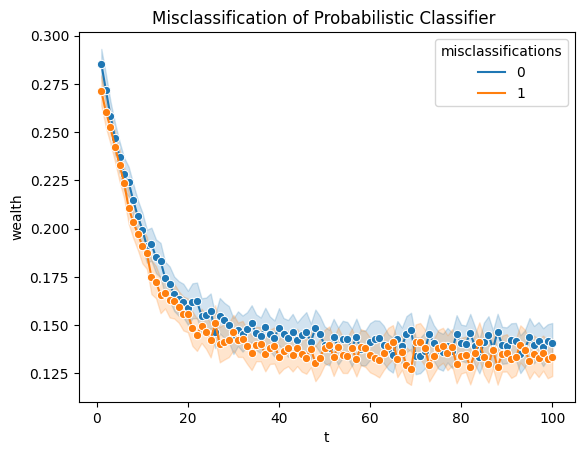

In [14]:
viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], abs(df_b['misclassifications']), title = 'Misclassification of Probabilistic Classifier ') #, df_baseline['convicted'])


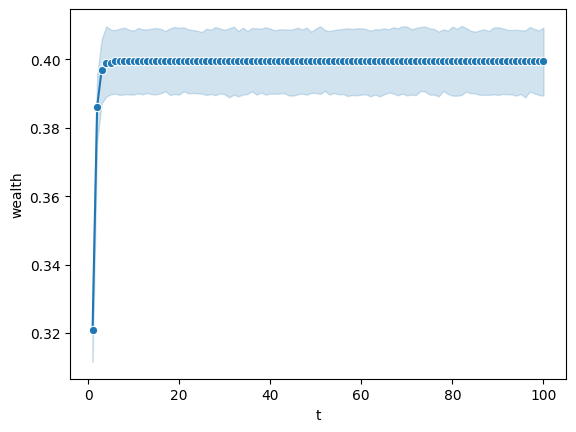

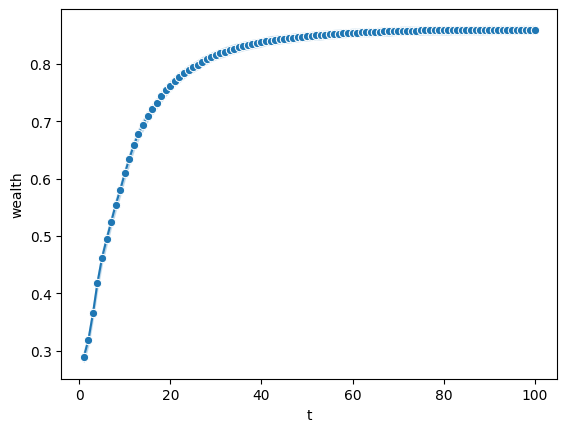

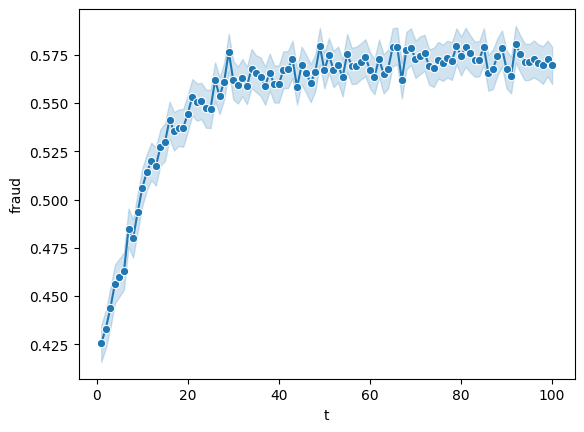

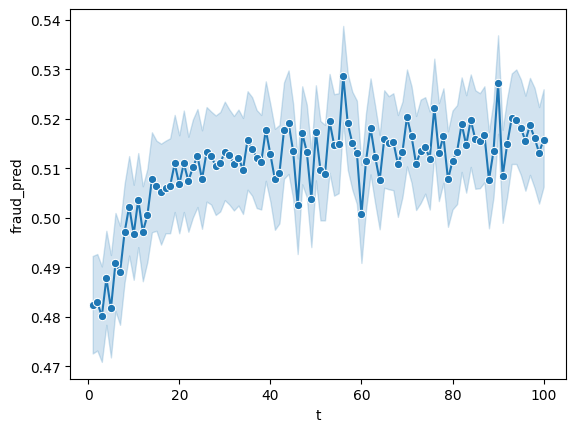

In [34]:
# viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], abs(df_b['misclassifications']), title = 'Misclassification of Probabilistic Classifier ') #, df_baseline['convicted'])

# viz(df_b, df_b.index.get_level_values('t'), df_b['fraud_pred'], df_b['race'], title= 'Probabilitic Classifier') #, df_baseline['convicted'])

# viz(df_b, df_b.index.get_level_values('t'), df_b['race'], df_b['fraud_pred'], title= 'Probabilitic Classifier') #, df_baseline['convicted'])


# viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud'],title= 'Probabilitic Classifier') #, df_baseline['convicted'])
viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth']<0.1)
viz2(df_b, df_b.index.get_level_values('t'), df_b['wealth']<0.1)
viz2(df_b, df_b.index.get_level_values('t'), df_b['fraud'])
viz2(df_b, df_b.index.get_level_values('t'), df_b['fraud_pred'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

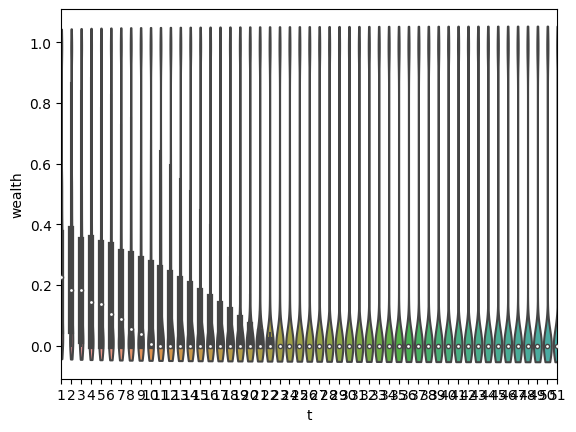

In [16]:
fig, ax = plt.subplots()

sns.violinplot(ax = ax,
                data = df_b,
                x = df_b.index.get_level_values('t'),
                y = df_b['wealth'], cut = True)

# plt.ylim(0,0.2)
plt.xlim(0,50)
# plt.title(title)

plt.show()

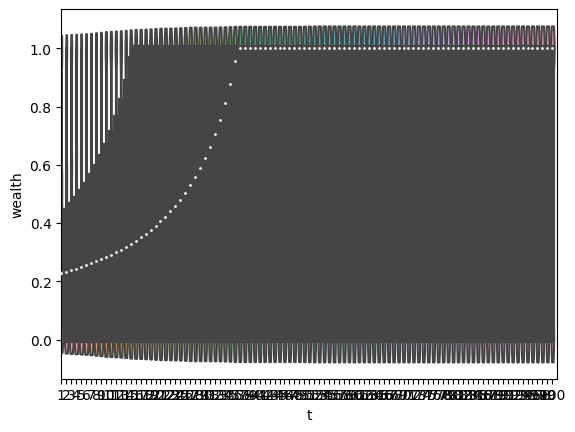

In [33]:
fig, ax = plt.subplots()

sns.violinplot(ax = ax,
                data = df_baseline,
                x = df_baseline.index.get_level_values('t'),
                y = df_baseline['wealth'], cut = True)

# plt.ylim(0,0.2)
plt.xlim(0,100)
# plt.title(title)

plt.show()

In [18]:

# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'],
#                 hue =df_b['fraud_pred'],
#                 marker = 'o' )

# sns.lineplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'],
#                 hue =df_b['fraud'],
#                 marker = 'x' )

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# plt.title('title')

# # viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud_pred']) #, df_baseline['convicted'])

# # viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud']) #, df_baseline['convicted'])